In [1]:
import firedrake
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from constants import *
from hs_solver import *
from phi_solver import *
from model import *

# Introduction
This is a python notebook that details experiments with a 1D-subglacial hydrology model meant to represent the co-evolution of a connected channel-sheet water system based on the Glacier Drainage System model, GlaDS. This model represents the work of many previous studies including the work of Ian Hewitt, Mauro Werder, and Christian Schoof.

# Synthetic mountain glacier
This is a synthetic domain meant to represent Mt. Baker. This is a 3-6km land terminating mountain glacier. Several functions that describe the geometry of this system are listed below. The "para" variable descibes the overdeepening of this glacier. I also descibe the formula for diurnally enhanced melt rates.

In [2]:
para_bench = 0.05
def surface(x,y):
    return firedrake.Constant(100.)*(x+firedrake.Constant(200.))**firedrake.Constant(1./4.) + firedrake.Constant(1./60.)*x - firedrake.Constant(2e10**(1./4.)) +firedrake.Constant(1.)
def bed(x,y,para):
    return f(x,para) + g(y)*h(x,para)
def f(x,para):
    return (surface(6e3,0.0) - para*6e3)/6e3**2 * x**2 + para*x
def g(y): 
    return 0.5e-6 *abs(y)**3.0
def h(x,para):
    return (-4.5*x/6e3 + 5.0) * (surface(x,0.0) -f(x,para))/(surface(x,0.0)-f(x,para_bench))
def outline(x):
    return ginv((surface(x,0)-f(x,0.05))/h(x,0.05))
def ginv(x):
    return (x/0.5e-6)**(1/3) 

In [3]:
########### Domain Geometry SHMIP part 2: Bench Glacier ############

Lx = 6e3
nx =600
flux_condition = 0.0
mesh = firedrake.IntervalMesh(nx,Lx)
degree = 1
V_cg = firedrake.FunctionSpace(mesh,"CG",degree)
para = 0.05

In [4]:
H=firedrake.Function(V_cg)
Bed=firedrake.Function(V_cg)
Surfacce=firedrake.Function(V_cg)
x = firedrake.SpatialCoordinate(mesh)
Surface=firedrake.interpolate(surface(x[0],0.0),V_cg)
Bed=firedrake.interpolate(bed(x[0],0.0,para),V_cg)
H=firedrake.interpolate(Surface-Bed,V_cg)
width = firedrake.interpolate(2.0*outline(x[0])/firedrake.Constant(100.0),V_cg)
width.dat.data[np.isnan(width.dat.data)]=0.0
ub = firedrake.Function(V_cg)

#slip velocity and melt rate defined in the SHMIP experiment.
ub=firedrake.interpolate(firedrake.Constant(1e-6),V_cg)
m = firedrake.interpolate((firedrake.Constant(1.0e-8)),V_cg)

In [5]:
########### Model Initializtion ############

h_init = firedrake.Function(V_cg)
h_init = firedrake.interpolate(Constant(1.0e-10),V_cg)
S_init = firedrake.Function(V_cg)


# Load potential at 0 pressure
phi_m = firedrake.Function(V_cg)
phi_m = firedrake.assemble(Bed*pcs['g']*pcs['rho_water'])
# Ice overburden pressure
p_i = firedrake.Function(V_cg)
p_i = firedrake.assemble(H*pcs['g']*pcs['rho_ice'])
# Enforce 0 pressure bc at margin
bc = firedrake.DirichletBC(V_cg,phi_m+p_i,1)

# Initialize hydropotential
phi_init=firedrake.Function(V_cg)
phi_init=p_i+phi_m

# change constants
pcs["e_v"]=1e-3
pcs["h_r"]=0.005

In [6]:
model_inputs = {}
model_inputs['phi_m'] = phi_m
model_inputs['p_i'] = p_i
model_inputs['phi_0'] = p_i+phi_m
model_inputs['mesh'] = mesh
model_inputs['H'] = H
model_inputs['B'] = Bed
model_inputs['u_b'] = ub
model_inputs['m'] = m
model_inputs['h_init'] = h_init
model_inputs['S_init'] = S_init
model_inputs['phi_init'] = phi_init
model_inputs['d_bcs'] = [bc]
model_inputs['width'] = width
model_inputs['out_dir'] = "outputs/"
model_inputs['constants'] = pcs

In [7]:
# Create the Glads model
baker = Glads1DModel(model_inputs)
# End time
T = 20.0*pcs['spd']
# Time step
dt = 60*30
#dirunal melt variation amplitude
R=1.0e-8

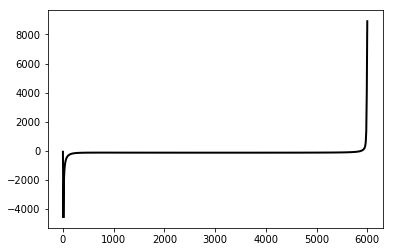

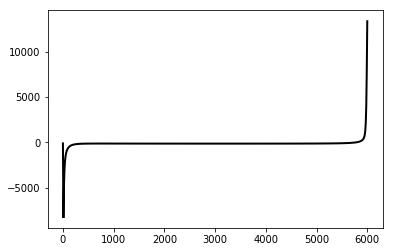

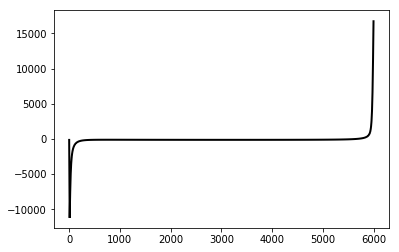

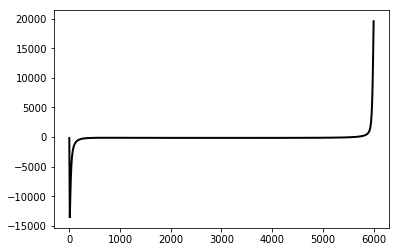

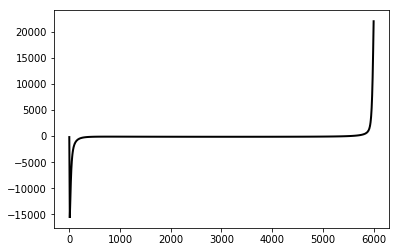

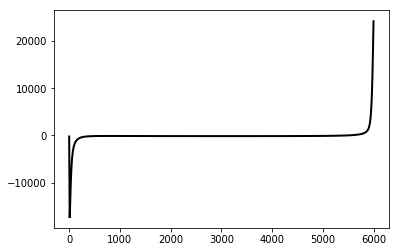

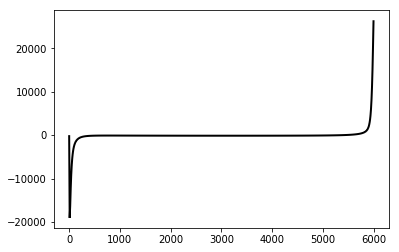

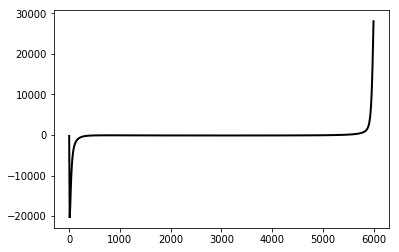

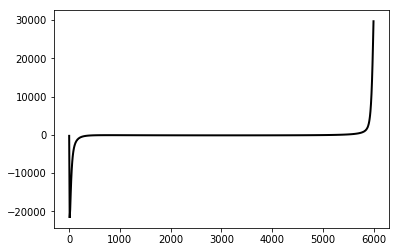

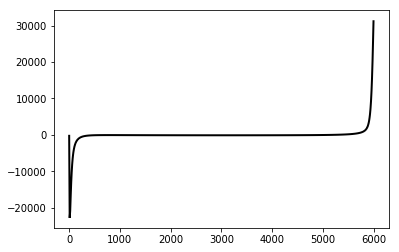

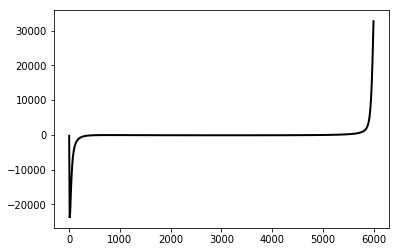

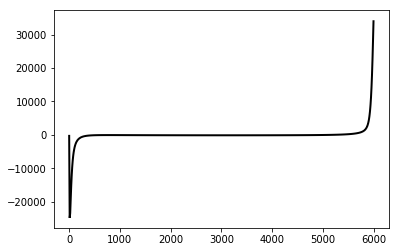

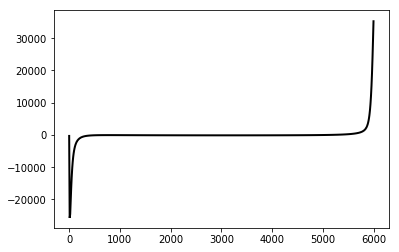

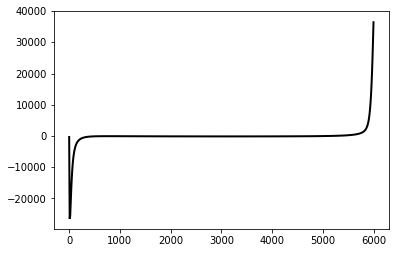

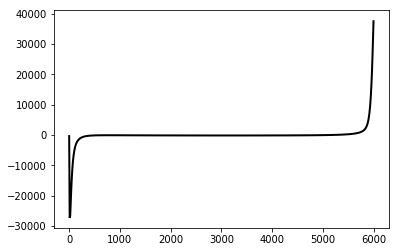

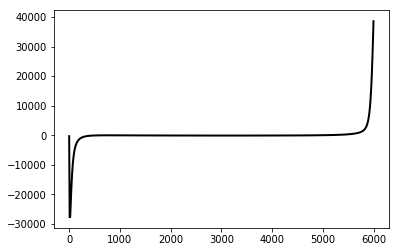

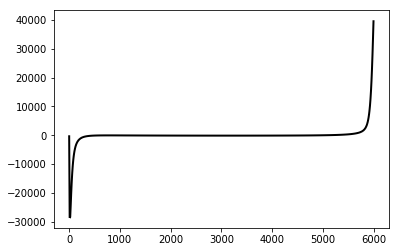

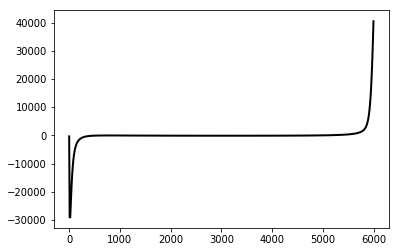

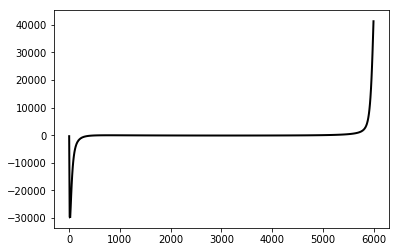

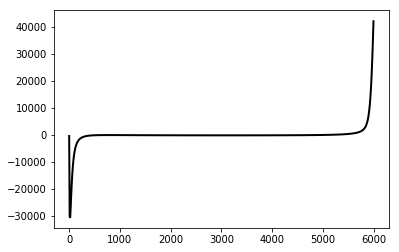

In [8]:
############# Run simulation ################

while baker.t < T:
    baker.step(dt)
    if (int(baker.t) % int(86400) ==0):
        plot(baker.N)


In [9]:
# diurnal simulation ################
Nss=baker.N.dat.data[:].copy()
Nfile = File("output/N.pvd")
Nanomalyfile =File("output/Nanomaly.pvd")
Sfile = File("output/S.pvd")
hfile = File("output/h.pvd")
phifile = File("output/phi.pvd")
Nanomaly=np.empty((0,nx+1))
Ndiurnal=np.empty((0,nx+1))
m_tmp=firedrake.Function(V_cg)
while baker.t <T+pcs['spd']:
    baker.step(60)
    Nanomaly=np.append(Nanomaly,np.array([baker.N.dat.data[:]-Nss]),axis=0)
    Ndiurnal = np.append(Ndiurnal,np.array([baker.N.dat.data[:]]),axis=0)
    m_tmp = firedrake.interpolate(firedrake.Constant(1.0e-8)+firedrake.Constant(R*(1-cos(2*pi*baker.t/pcs['spd']))),V_cg)
    baker.modelinputs['m'] = m_tmp

AttributeError: 'Glads1DModel' object has no attribute 'modelinputs'

In [ ]:
fig = plt.figure(dpi=1200)
ax = fig.add_subplot(111)
plt.xlabel('distance.(km)',fontsize=18)
plt.ylabel('velocity.(m/year)',fontsize=18)
plt.imshow(Ndiurnal)
plt.colorbar()
plt.show()